## Tentativa de Previsão de Oleo com base em dados Multivariados

#### Carregando libs necessárias

In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential
# from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error , mean_squared_error
import optuna
# pip install optuna
!pip install optuna-integration


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Função para a preparação dos dados para o modelo de previsão

In [2]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

#### Carregando a base de dados

In [3]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


#### Verificação se todos os dados da base são referentes a um poço produtor

In [4]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()

DATEPRD                       0
WELL_BORE_CODE                0
NPD_WELL_BORE_CODE            0
NPD_WELL_BORE_NAME            0
NPD_FIELD_CODE                0
NPD_FIELD_NAME                0
NPD_FACILITY_CODE             0
NPD_FACILITY_NAME             0
ON_STREAM_HRS                 0
AVG_DOWNHOLE_PRESSURE         3
AVG_DOWNHOLE_TEMPERATURE      3
AVG_DP_TUBING                 3
AVG_ANNULUS_PRESS           728
AVG_CHOKE_SIZE_P              0
AVG_CHOKE_UOM                 0
AVG_WHP_P                     0
AVG_WHT_P                     0
DP_CHOKE_SIZE                 0
BORE_OIL_VOL                  0
BORE_GAS_VOL                  0
BORE_WAT_VOL                  0
BORE_WI_VOL                 744
FLOW_KIND                     0
WELL_TYPE                     0
dtype: int64

#### Remoção de colunas desnecessárias

In [5]:
df_filter=df_filter.drop(columns=['WELL_BORE_CODE','NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
                                  'NPD_FIELD_CODE','NPD_FIELD_NAME',
                                  'NPD_FACILITY_CODE','NPD_FACILITY_NAME',
                                  'AVG_CHOKE_UOM','FLOW_KIND',
                                  'WELL_TYPE','BORE_WI_VOL'])

#### Plot de todos os dados da base de dados

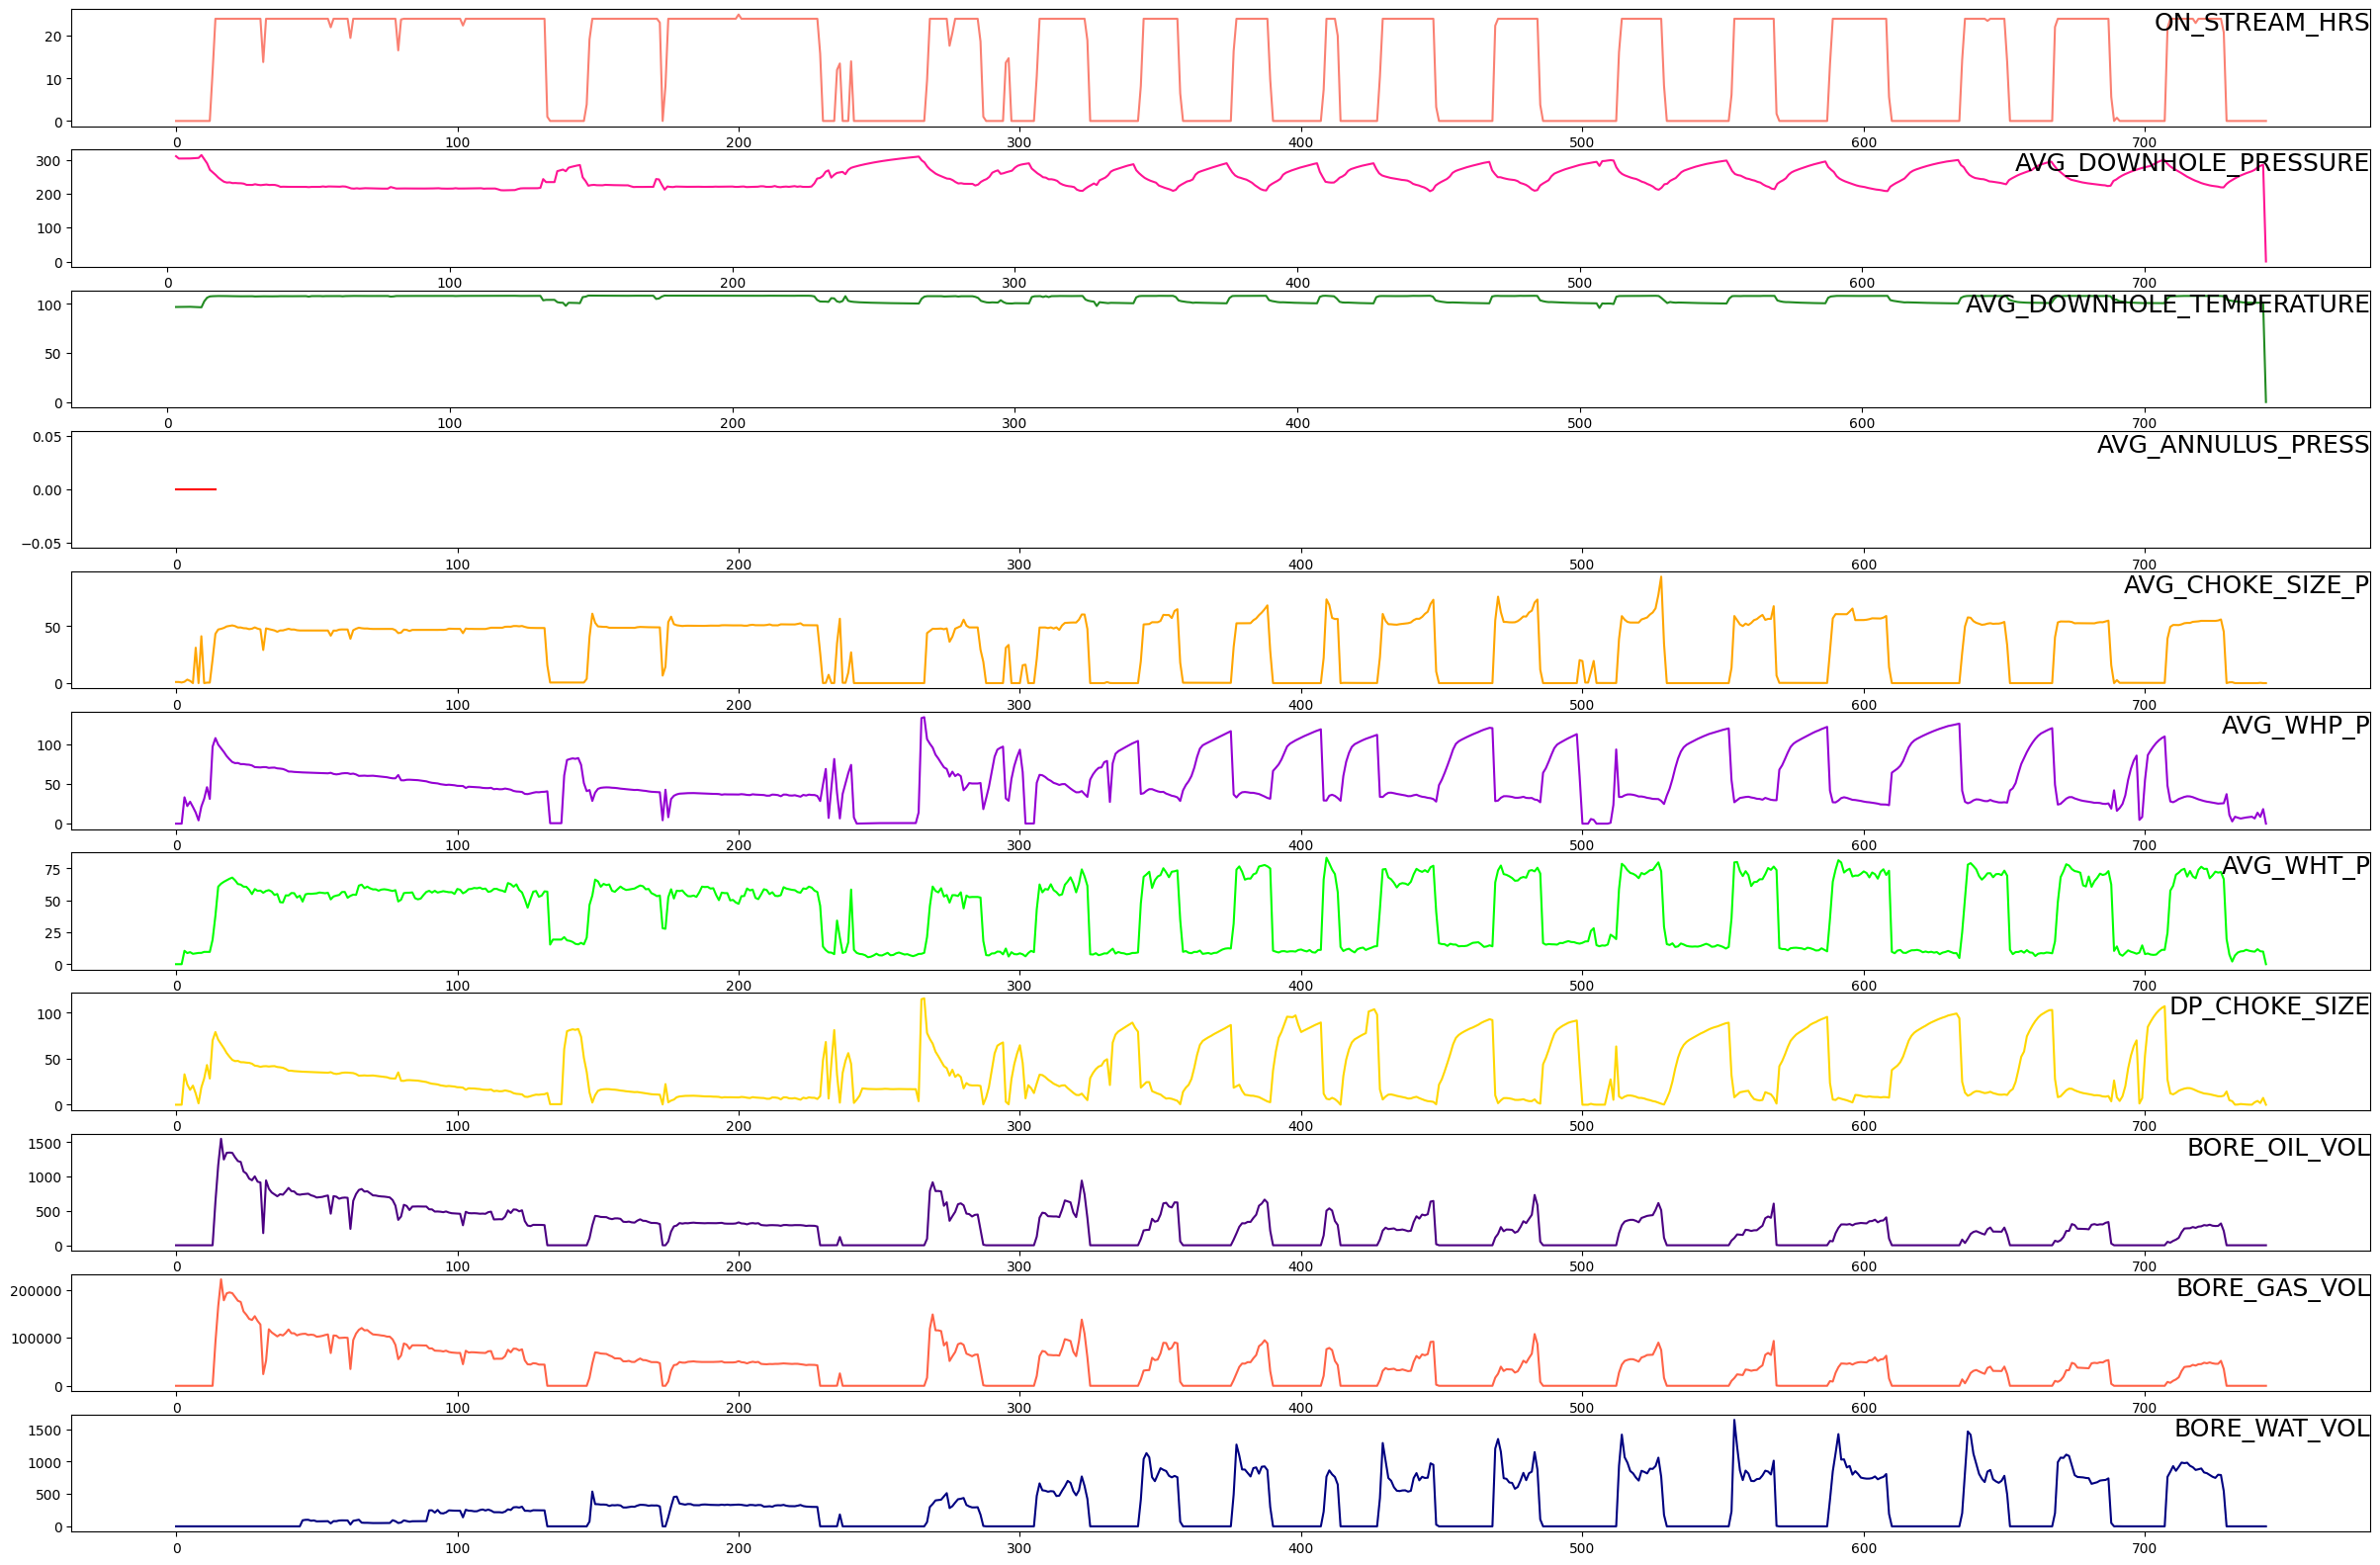

In [6]:
values = df_filter.values

# specify columns to plot
groups = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
i = 1
colors=['blue','salmon','deeppink',"forestgreen",'red','orange','darkviolet','lime','gold','indigo','tomato','navy']

# plot each column
plt.figure(figsize=(30,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = colors[i])
    plt.title(df_filter.columns[group], y=0.75, loc='right', fontsize = 18)
    i += 1
plt.show()

#### Filtro para selecionar apenas as features desejadas

In [7]:
target = df_filter[['BORE_OIL_VOL','BORE_WAT_VOL','BORE_GAS_VOL','AVG_WHP_P','AVG_WHT_P','ON_STREAM_HRS']]

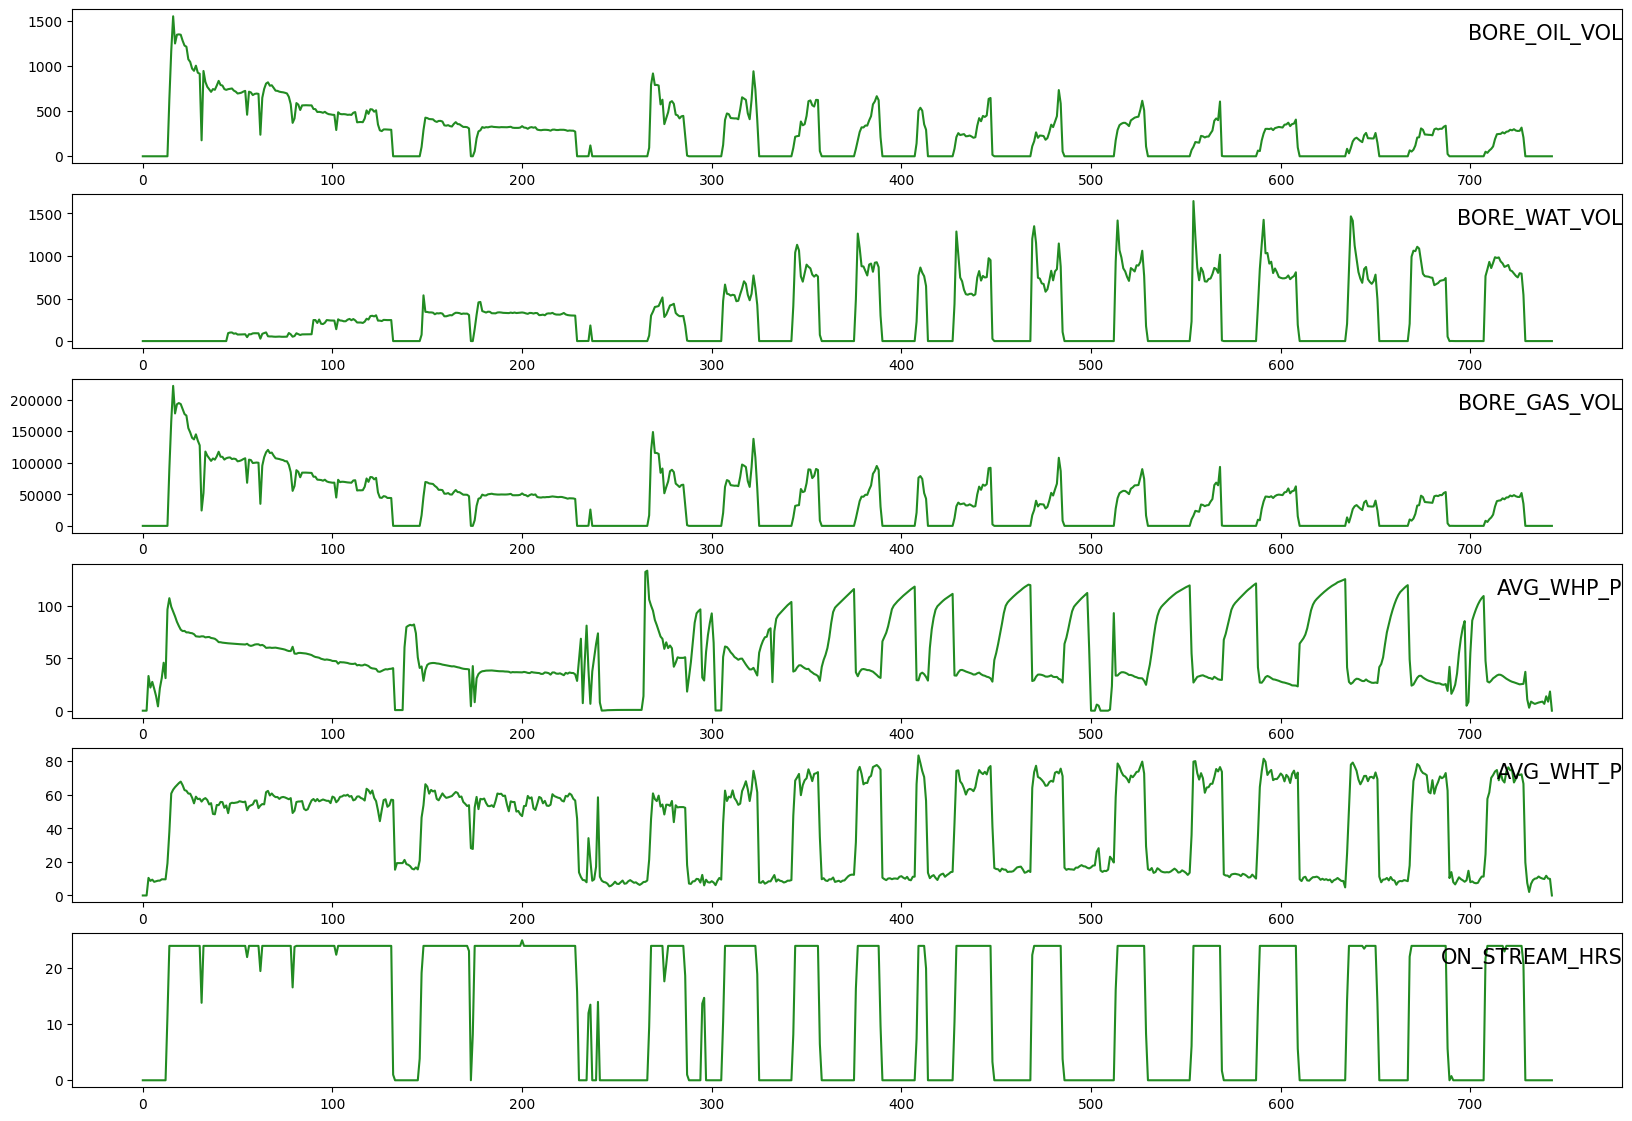

In [8]:
values = target.values

# specify columns to plot
groups = [0, 1, 2, 3, 4,5]
i = 1
# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(target.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

#### Visualização do perfil completo da produção de Oleo

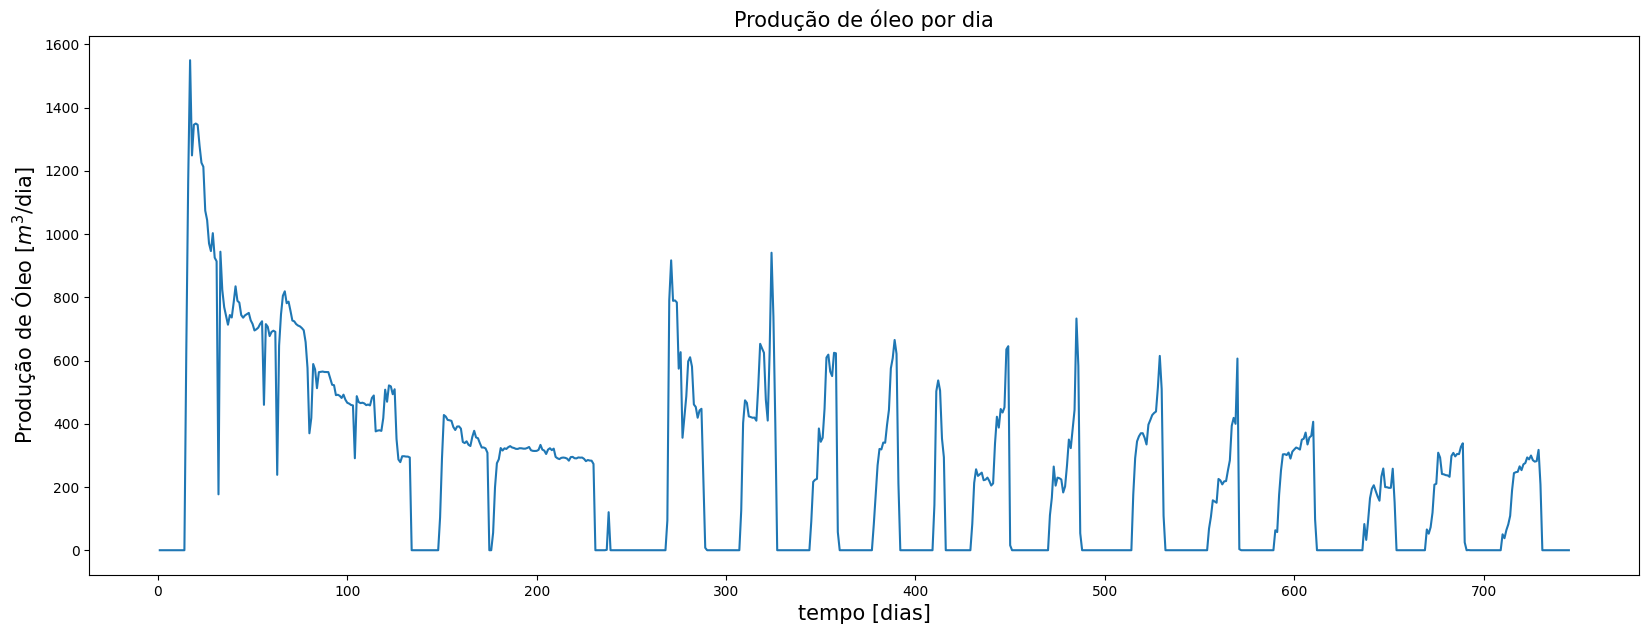

In [9]:
fig = plt.figure(figsize = (20,7))
plt.plot(target.BORE_OIL_VOL)
plt.title("Produção de óleo por dia", fontsize = 15)
plt.xlabel('tempo [dias]', fontsize = 15)
plt.ylabel(r'Produção de Óleo [$m^3$/dia]', fontsize = 15)  # LaTeX formatting for the y-label
plt.show()

#### Heatmap da correlação entre os dados

<Axes: >

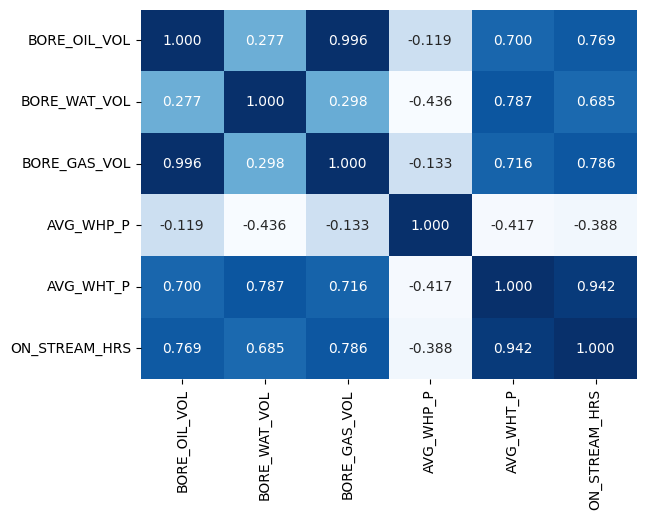

In [10]:
sns.heatmap(target.corr(),annot=True, cbar=False, cmap='Blues', fmt='.3f')

#### Preparação da base de dados para criação do modelo

In [11]:
# Scaling the entire dataset

dataset = target
values = dataset.values

values = values.astype('float32')

# Fazendo uma normalização nos dados para ficarem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Vamos jogar o Optuna apartir desse ponto

In [12]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [13]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [14]:
epochs = 300 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [15]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 1, 100)  # Adjust the range as needed
    batch_size = 1#trial.suggest_int('window_size', 1, 30)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 10)
    lstm_units = 50#trial.suggest_int('lstm_units', 32, 256)
    learning_rate = 1e-4#trial.suggest_float('learning_rate', 1e-4, 1e-2)

    ## Create the dataset
    reframed = series_to_supervised(scaled, window_size, 1)

    # droping columns we don't want to predict
    columns_to_drop = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)']
    reframed.drop(columns_to_drop, axis=1, inplace=True)

    train_ratio = 0.8

    # Split the dataset into train and test sets
    split_index = int(len(target) * train_ratio)

    
    values = reframed.values

    # We train the model on the 1st 3 years and then test on the last year (for now)
    n_train_hours = split_index

    train = values[:split_index, :]
    test = values[split_index:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(1))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
    
    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)

    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_multivariable_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss

In [16]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')

[I 2023-10-20 09:24:28,582] A new study created in memory with name: no-name-4c269277-4862-4f47-b93b-fac8351eb411


In [17]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=100)

INFO:tensorflow:Assets written to: ram://4159270d-fc4a-4b9b-b94a-04c07dd852e8/assets


INFO:tensorflow:Assets written to: ram://4159270d-fc4a-4b9b-b94a-04c07dd852e8/assets
[I 2023-10-20 09:44:49,276] Trial 0 finished with value: 0.0027487906627357006 and parameters: {'window_size': 74, 'n_lstm_layers': 8}. Best is trial 0 with value: 0.0027487906627357006.


INFO:tensorflow:Assets written to: ram://79714803-728e-46d5-ad79-6ca190479ea6/assets


INFO:tensorflow:Assets written to: ram://79714803-728e-46d5-ad79-6ca190479ea6/assets
[I 2023-10-20 10:07:56,828] Trial 1 finished with value: 0.0019244804279878736 and parameters: {'window_size': 6, 'n_lstm_layers': 9}. Best is trial 1 with value: 0.0019244804279878736.


INFO:tensorflow:Assets written to: ram://92821012-6f1b-4971-9b51-1153431556b0/assets


INFO:tensorflow:Assets written to: ram://92821012-6f1b-4971-9b51-1153431556b0/assets
[I 2023-10-20 10:28:13,829] Trial 2 finished with value: 0.0022036973387002945 and parameters: {'window_size': 75, 'n_lstm_layers': 8}. Best is trial 1 with value: 0.0019244804279878736.


INFO:tensorflow:Assets written to: ram://68f7e1f9-8f2b-4279-91f6-7c522c0bff2f/assets


INFO:tensorflow:Assets written to: ram://68f7e1f9-8f2b-4279-91f6-7c522c0bff2f/assets
[I 2023-10-20 10:34:48,045] Trial 3 finished with value: 0.0016987895360216498 and parameters: {'window_size': 85, 'n_lstm_layers': 1}. Best is trial 3 with value: 0.0016987895360216498.


INFO:tensorflow:Assets written to: ram://bdd8d44b-7dbb-4f92-b490-f6799e3b295d/assets


INFO:tensorflow:Assets written to: ram://bdd8d44b-7dbb-4f92-b490-f6799e3b295d/assets
[I 2023-10-20 10:57:46,798] Trial 4 finished with value: 0.0015860672574490309 and parameters: {'window_size': 3, 'n_lstm_layers': 9}. Best is trial 4 with value: 0.0015860672574490309.
[I 2023-10-20 10:57:54,223] Trial 5 pruned. 
[I 2023-10-20 10:58:11,806] Trial 6 pruned. 
[I 2023-10-20 10:58:25,903] Trial 7 pruned. 
[I 2023-10-20 10:58:36,891] Trial 8 pruned. 
[I 2023-10-20 10:58:46,674] Trial 9 pruned. 
[I 2023-10-20 10:58:59,848] Trial 10 pruned. 


INFO:tensorflow:Assets written to: ram://3d300ab5-87a2-4618-b2f6-027a8be531e5/assets


INFO:tensorflow:Assets written to: ram://3d300ab5-87a2-4618-b2f6-027a8be531e5/assets
[I 2023-10-20 11:05:17,843] Trial 11 finished with value: 0.002165930112823844 and parameters: {'window_size': 100, 'n_lstm_layers': 1}. Best is trial 4 with value: 0.0015860672574490309.


INFO:tensorflow:Assets written to: ram://002d29b9-70ef-48f6-b7ef-f89f6e3db305/assets


INFO:tensorflow:Assets written to: ram://002d29b9-70ef-48f6-b7ef-f89f6e3db305/assets
[I 2023-10-20 11:15:35,156] Trial 12 finished with value: 0.0015802993439137936 and parameters: {'window_size': 97, 'n_lstm_layers': 3}. Best is trial 12 with value: 0.0015802993439137936.


INFO:tensorflow:Assets written to: ram://a5c94b85-8307-4d78-9d70-0e9e5362f1af/assets


INFO:tensorflow:Assets written to: ram://a5c94b85-8307-4d78-9d70-0e9e5362f1af/assets
[I 2023-10-20 11:25:44,721] Trial 13 finished with value: 0.0018885399913415313 and parameters: {'window_size': 100, 'n_lstm_layers': 3}. Best is trial 12 with value: 0.0015802993439137936.
[I 2023-10-20 11:26:22,436] Trial 14 pruned. 
[I 2023-10-20 11:26:31,641] Trial 15 pruned. 
[I 2023-10-20 11:27:02,603] Trial 16 pruned. 
[I 2023-10-20 11:27:11,216] Trial 17 pruned. 


INFO:tensorflow:Assets written to: ram://e143b71b-71a2-4b25-952f-8cdfd9989558/assets


INFO:tensorflow:Assets written to: ram://e143b71b-71a2-4b25-952f-8cdfd9989558/assets
[I 2023-10-20 11:37:27,973] Trial 18 finished with value: 0.001365877571515739 and parameters: {'window_size': 85, 'n_lstm_layers': 3}. Best is trial 18 with value: 0.001365877571515739.
[I 2023-10-20 11:37:33,209] Trial 19 pruned. 
[I 2023-10-20 11:37:40,008] Trial 20 pruned. 
[I 2023-10-20 11:37:49,651] Trial 21 pruned. 
[I 2023-10-20 11:38:02,623] Trial 22 pruned. 


INFO:tensorflow:Assets written to: ram://ff1b0d96-2eb9-491b-987b-e596b370ebf3/assets


INFO:tensorflow:Assets written to: ram://ff1b0d96-2eb9-491b-987b-e596b370ebf3/assets
[I 2023-10-20 11:50:23,448] Trial 23 finished with value: 0.0009650447173044086 and parameters: {'window_size': 94, 'n_lstm_layers': 4}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://bd1f8c28-5e93-473c-9a4e-094825a643c5/assets


INFO:tensorflow:Assets written to: ram://bd1f8c28-5e93-473c-9a4e-094825a643c5/assets
[I 2023-10-20 12:02:43,025] Trial 24 finished with value: 0.0010533169843256474 and parameters: {'window_size': 95, 'n_lstm_layers': 4}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://bde4c70e-54f7-4c12-9a63-6821c626f363/assets


INFO:tensorflow:Assets written to: ram://bde4c70e-54f7-4c12-9a63-6821c626f363/assets
[I 2023-10-20 12:15:03,937] Trial 25 finished with value: 0.0020910424645990133 and parameters: {'window_size': 91, 'n_lstm_layers': 4}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 12:15:11,379] Trial 26 pruned. 


INFO:tensorflow:Assets written to: ram://87bb7066-4021-4fa8-be2b-056e3e0b2722/assets


INFO:tensorflow:Assets written to: ram://87bb7066-4021-4fa8-be2b-056e3e0b2722/assets
[I 2023-10-20 12:23:35,137] Trial 27 finished with value: 0.0018236096948385239 and parameters: {'window_size': 80, 'n_lstm_layers': 2}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 12:23:41,638] Trial 28 pruned. 
[I 2023-10-20 12:23:50,297] Trial 29 pruned. 
[I 2023-10-20 12:23:54,346] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://24099b9b-e1c7-4177-8093-815ef10ca92f/assets


INFO:tensorflow:Assets written to: ram://24099b9b-e1c7-4177-8093-815ef10ca92f/assets
[I 2023-10-20 12:34:11,142] Trial 31 finished with value: 0.0010565364500507712 and parameters: {'window_size': 95, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://1a4b1b8a-e964-45e0-bee6-69dc3114740c/assets


INFO:tensorflow:Assets written to: ram://1a4b1b8a-e964-45e0-bee6-69dc3114740c/assets
[I 2023-10-20 12:46:30,351] Trial 32 finished with value: 0.0018481293227523565 and parameters: {'window_size': 93, 'n_lstm_layers': 4}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://0dc392a1-02f7-4405-bef1-76fb7c89b84a/assets


INFO:tensorflow:Assets written to: ram://0dc392a1-02f7-4405-bef1-76fb7c89b84a/assets
[I 2023-10-20 12:56:47,845] Trial 33 finished with value: 0.0010517705231904984 and parameters: {'window_size': 94, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 12:56:55,269] Trial 34 pruned. 
[I 2023-10-20 12:57:00,114] Trial 35 pruned. 
[I 2023-10-20 12:57:06,523] Trial 36 pruned. 
[I 2023-10-20 12:57:10,635] Trial 37 pruned. 
[I 2023-10-20 12:57:18,152] Trial 38 pruned. 


INFO:tensorflow:Assets written to: ram://1376892e-502c-450b-be17-b683026d1350/assets


INFO:tensorflow:Assets written to: ram://1376892e-502c-450b-be17-b683026d1350/assets
[I 2023-10-20 13:07:29,524] Trial 39 finished with value: 0.0013853972777724266 and parameters: {'window_size': 96, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 13:07:39,200] Trial 40 pruned. 
[I 2023-10-20 13:07:45,186] Trial 41 pruned. 


INFO:tensorflow:Assets written to: ram://228c5c5c-b7f4-4dd7-b246-eaa68e124720/assets


INFO:tensorflow:Assets written to: ram://228c5c5c-b7f4-4dd7-b246-eaa68e124720/assets
[I 2023-10-20 13:17:57,305] Trial 42 finished with value: 0.0018095980631187558 and parameters: {'window_size': 100, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 13:18:03,558] Trial 43 pruned. 
[I 2023-10-20 13:18:08,342] Trial 44 pruned. 
[I 2023-10-20 13:18:11,296] Trial 45 pruned. 
[I 2023-10-20 13:18:18,784] Trial 46 pruned. 


INFO:tensorflow:Assets written to: ram://e864ff47-e158-4493-a21f-80782a7204aa/assets


INFO:tensorflow:Assets written to: ram://e864ff47-e158-4493-a21f-80782a7204aa/assets
[I 2023-10-20 13:28:29,076] Trial 47 finished with value: 0.0015305292326956987 and parameters: {'window_size': 97, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 13:28:36,075] Trial 48 pruned. 
[I 2023-10-20 13:28:40,186] Trial 49 pruned. 
[I 2023-10-20 13:28:45,626] Trial 50 pruned. 


INFO:tensorflow:Assets written to: ram://fb30cc77-6655-46c2-afff-1de5a14a6882/assets


INFO:tensorflow:Assets written to: ram://fb30cc77-6655-46c2-afff-1de5a14a6882/assets
[I 2023-10-20 13:39:01,966] Trial 51 finished with value: 0.0012339608510956168 and parameters: {'window_size': 97, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://88f7d319-c0e0-49f4-9022-d04a5129e0fc/assets


INFO:tensorflow:Assets written to: ram://88f7d319-c0e0-49f4-9022-d04a5129e0fc/assets
[I 2023-10-20 13:49:10,170] Trial 52 finished with value: 0.0014769937843084335 and parameters: {'window_size': 100, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 13:49:17,004] Trial 53 pruned. 


INFO:tensorflow:Assets written to: ram://80262ac8-29f9-4cbb-86c8-89f63fb575fb/assets


INFO:tensorflow:Assets written to: ram://80262ac8-29f9-4cbb-86c8-89f63fb575fb/assets
[I 2023-10-20 13:57:40,015] Trial 54 finished with value: 0.0019136093324050307 and parameters: {'window_size': 96, 'n_lstm_layers': 2}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://89be2c54-5a62-47d4-a180-7e56dd9de173/assets


INFO:tensorflow:Assets written to: ram://89be2c54-5a62-47d4-a180-7e56dd9de173/assets
[I 2023-10-20 14:07:52,002] Trial 55 finished with value: 0.0012562607880681753 and parameters: {'window_size': 97, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 14:07:59,979] Trial 56 pruned. 
[I 2023-10-20 14:08:06,543] Trial 57 pruned. 
[I 2023-10-20 14:08:11,998] Trial 58 pruned. 
[I 2023-10-20 14:08:16,171] Trial 59 pruned. 


INFO:tensorflow:Assets written to: ram://c21279e5-2027-4be1-8db5-52810d72ede9/assets


INFO:tensorflow:Assets written to: ram://c21279e5-2027-4be1-8db5-52810d72ede9/assets
[I 2023-10-20 14:18:27,032] Trial 60 finished with value: 0.00168274634052068 and parameters: {'window_size': 100, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.
[I 2023-10-20 14:18:32,147] Trial 61 pruned. 
[I 2023-10-20 14:18:39,119] Trial 62 pruned. 
[I 2023-10-20 14:18:43,167] Trial 63 pruned. 
[I 2023-10-20 14:18:48,638] Trial 64 pruned. 
[I 2023-10-20 14:18:55,000] Trial 65 pruned. 


INFO:tensorflow:Assets written to: ram://8ad452b2-07de-408a-bff9-47fe0beaadad/assets


INFO:tensorflow:Assets written to: ram://8ad452b2-07de-408a-bff9-47fe0beaadad/assets
[I 2023-10-20 14:29:14,235] Trial 66 finished with value: 0.0012744268169626594 and parameters: {'window_size': 98, 'n_lstm_layers': 3}. Best is trial 23 with value: 0.0009650447173044086.


INFO:tensorflow:Assets written to: ram://b8372074-5f24-4c3a-a6ca-82eb3ca8df61/assets


INFO:tensorflow:Assets written to: ram://b8372074-5f24-4c3a-a6ca-82eb3ca8df61/assets
[I 2023-10-20 14:39:25,075] Trial 67 finished with value: 0.0006652505253441632 and parameters: {'window_size': 97, 'n_lstm_layers': 3}. Best is trial 67 with value: 0.0006652505253441632.
[I 2023-10-20 14:39:32,047] Trial 68 pruned. 
[I 2023-10-20 14:39:43,942] Trial 69 pruned. 
[I 2023-10-20 14:39:48,474] Trial 70 pruned. 


INFO:tensorflow:Assets written to: ram://7d724a90-b3df-4b8d-8f02-a24707f9fe43/assets


INFO:tensorflow:Assets written to: ram://7d724a90-b3df-4b8d-8f02-a24707f9fe43/assets
[I 2023-10-20 14:50:02,973] Trial 71 finished with value: 0.0020055598579347134 and parameters: {'window_size': 98, 'n_lstm_layers': 3}. Best is trial 67 with value: 0.0006652505253441632.
[I 2023-10-20 14:50:08,845] Trial 72 pruned. 


INFO:tensorflow:Assets written to: ram://9d2e95b3-3c9c-44f6-9fe9-36f29347f7ce/assets


INFO:tensorflow:Assets written to: ram://9d2e95b3-3c9c-44f6-9fe9-36f29347f7ce/assets
[I 2023-10-20 15:02:30,054] Trial 73 finished with value: 0.00234194565564394 and parameters: {'window_size': 98, 'n_lstm_layers': 4}. Best is trial 67 with value: 0.0006652505253441632.


INFO:tensorflow:Assets written to: ram://86d46eea-e33d-4269-baa2-a0feb5620304/assets


INFO:tensorflow:Assets written to: ram://86d46eea-e33d-4269-baa2-a0feb5620304/assets
[I 2023-10-20 15:12:47,729] Trial 74 finished with value: 0.0013742073206230998 and parameters: {'window_size': 95, 'n_lstm_layers': 3}. Best is trial 67 with value: 0.0006652505253441632.
[I 2023-10-20 15:12:51,852] Trial 75 pruned. 
[I 2023-10-20 15:13:00,026] Trial 76 pruned. 
[I 2023-10-20 15:13:03,027] Trial 77 pruned. 
[I 2023-10-20 15:13:08,592] Trial 78 pruned. 
[I 2023-10-20 15:13:15,063] Trial 79 pruned. 
[I 2023-10-20 15:13:19,143] Trial 80 pruned. 
[I 2023-10-20 15:13:24,582] Trial 81 pruned. 
[I 2023-10-20 15:13:29,990] Trial 82 pruned. 
[I 2023-10-20 15:13:36,649] Trial 83 pruned. 
[I 2023-10-20 15:13:42,010] Trial 84 pruned. 
[I 2023-10-20 15:13:47,654] Trial 85 pruned. 
[I 2023-10-20 15:13:56,375] Trial 86 pruned. 
[I 2023-10-20 15:14:00,549] Trial 87 pruned. 


INFO:tensorflow:Assets written to: ram://b6d3784b-2534-4cec-88e4-0ef3147975cb/assets


INFO:tensorflow:Assets written to: ram://b6d3784b-2534-4cec-88e4-0ef3147975cb/assets
[I 2023-10-20 15:26:28,394] Trial 88 finished with value: 0.0015015205135568976 and parameters: {'window_size': 98, 'n_lstm_layers': 4}. Best is trial 67 with value: 0.0006652505253441632.
[I 2023-10-20 15:26:36,032] Trial 89 pruned. 
[I 2023-10-20 15:26:42,284] Trial 90 pruned. 


INFO:tensorflow:Assets written to: ram://d8ae03ed-e1e6-4ac1-8a19-b9c3baeee41a/assets


INFO:tensorflow:Assets written to: ram://d8ae03ed-e1e6-4ac1-8a19-b9c3baeee41a/assets
[I 2023-10-20 15:37:01,841] Trial 91 finished with value: 0.0016828671796247363 and parameters: {'window_size': 95, 'n_lstm_layers': 3}. Best is trial 67 with value: 0.0006652505253441632.


INFO:tensorflow:Assets written to: ram://a13f16f7-6fb8-4534-8d0b-2e9cd084ae17/assets


INFO:tensorflow:Assets written to: ram://a13f16f7-6fb8-4534-8d0b-2e9cd084ae17/assets
[I 2023-10-20 15:45:22,664] Trial 92 finished with value: 0.0011089809704571962 and parameters: {'window_size': 100, 'n_lstm_layers': 2}. Best is trial 67 with value: 0.0006652505253441632.
[I 2023-10-20 15:45:25,787] Trial 93 pruned. 
[I 2023-10-20 15:45:30,679] Trial 94 pruned. 
[I 2023-10-20 15:45:34,822] Trial 95 pruned. 
[I 2023-10-20 15:45:41,451] Trial 96 pruned. 
[I 2023-10-20 15:45:45,532] Trial 97 pruned. 


INFO:tensorflow:Assets written to: ram://892f8cfe-f079-4ebe-bc7d-e354d3e5a399/assets


INFO:tensorflow:Assets written to: ram://892f8cfe-f079-4ebe-bc7d-e354d3e5a399/assets
[I 2023-10-20 15:55:57,268] Trial 98 finished with value: 0.0009280731319449842 and parameters: {'window_size': 96, 'n_lstm_layers': 3}. Best is trial 67 with value: 0.0006652505253441632.


INFO:tensorflow:Assets written to: ram://c4b86762-3ee7-4b57-a6a6-8fcf0d94aef6/assets


INFO:tensorflow:Assets written to: ram://c4b86762-3ee7-4b57-a6a6-8fcf0d94aef6/assets
[I 2023-10-20 16:06:17,903] Trial 99 finished with value: 0.001241534948348999 and parameters: {'window_size': 96, 'n_lstm_layers': 3}. Best is trial 67 with value: 0.0006652505253441632.


In [18]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 97, 'n_lstm_layers': 3}
Best Validation Loss: 0.0006652505253441632


In [19]:
# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']# Adjust the range as needed
batch_size = 1#trial.suggest_int('window_size', 1, 30)  # Adjust the range as needed
# n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 10)
lstm_units = 50#trial.suggest_int('lstm_units', 32, 256)
learning_rate = 1e-4#trial.suggest_float('learning_rate', 1e-4, 1e-2)

## Create the dataset
reframed = series_to_supervised(scaled, window_size, 1)

# droping columns we don't want to predict
columns_to_drop = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)']
reframed.drop(columns_to_drop, axis=1, inplace=True)

train_ratio = 0.8

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

    
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = split_index

train = values[:split_index, :]
test = values[split_index:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(1))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
    

# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(train_X, train_y, epochs=epochs, batch_size=1, validation_data=(test_X, test_y), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [20]:
testPredict = best_model_LSTM.predict(test_X)
print(testPredict.shape)
testPredict_scaled = testPredict.ravel()

print(testPredict_scaled.shape)

2/2 [==============================] - 1s 0s/step
(52, 1)
(52,)


In [21]:
y_test_true_scaled = test_y

#### Recuperando a escala dos dados

In [22]:
poll = np.array(target["BORE_OIL_VOL"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true_scaled * stdop + meanop
testPredict = testPredict_scaled * stdop + meanop

#### Plotando a resposta final do processo

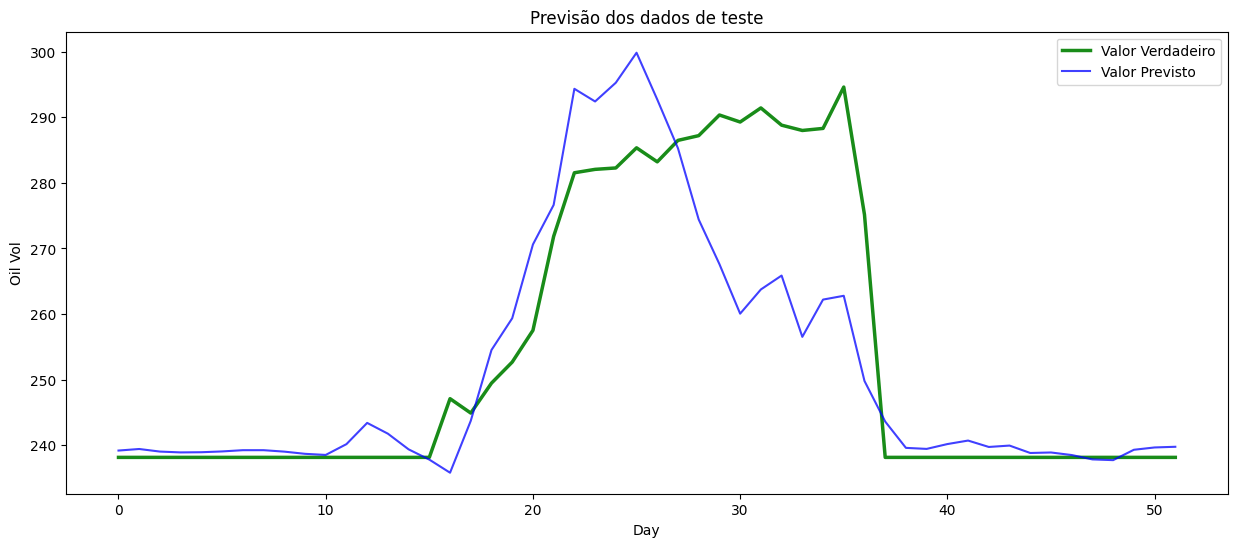

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
# plt.xlim([1000,1250])
plt.ylabel("Oil Vol")
plt.xlabel("Day")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5,label='Valor Verdadeiro')
plt.plot(testPredict, c = "b", alpha = 0.75,label='Valor Previsto')
plt.legend()
plt.title("Previsão dos dados de teste")
plt.show()

In [24]:
rmse = np.sqrt(mean_squared_error(y_test_true_scaled, testPredict_scaled))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 0.04327224


In [25]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 11.925229


In [26]:
optuna.visualization.plot_contour(study)

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_intermediate_values(study)